# Imports

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline

# Tensorflow backend initialization

In [55]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

Amount of GPUs available: 4


# Function definitions

In [1]:
def create_corr_matrix(df, dwelling_id, annot):
    """
    Pearson correlation coefficient matrix. 
    The Pearson correlation coefficient is a measure of the linear correlation between two variables.
    """
    plt.clf()
    
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    if annot:
        fig, ax = plt.subplots(figsize=(25,25))
    else:
        fig, ax = plt.subplots()

    fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=annot, ax=ax, 
                cbar_kws={'label':'Pearson correlation coefficient [-]'})

    fig.set_title('Correlation matrix of dwelling ID: '+dwelling_id)
    fig.tick_params(axis='x', rotation=90)
    fig.tick_params(axis='y', rotation=0)

    fig = fig.get_figure()
    fig.tight_layout()
    fig.show()
    
    print('Saving heatmap')
    #fig.savefig('//datc//opschaler//EDA//Pearson_corr//' + dwelling_id + '.png', dpi=300)
    return fig


def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df


def resample_df(df, sample_rate):
    """
    Temp. fix for the 
    Resampled a (un)processed dataframe to the specified sample_rate.
    Input is a (un)processed df
    Sample rate must be a string. 
    For example '1H', '1D', '60s'.
    """
    new_df = df.drop(['gasPower'], axis=1) # Drop gasPower, calculate it again later
    
    to_sum = ['eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'ePower', 'ePowerReturn'] # resampler.sum() these columns
    to_last = ['gasMeter', 'eMeter'] # resample.last(), take last known value from the columns
    
    new_df[to_sum] = new_df[to_sum].resample(sample_rate).sum() # sum values
    new_df[to_last] = new_df[to_last].resample(sample_rate).last() # take last value most nearby the sample_rate
    new_df = new_df.resample(sample_rate).mean() # resample to 1H by mean (this wont change the values calculated by .sum() and .last())
    
    # Calculate gasPower
    new_df['gasPower'] = new_df['gasMeter'].diff()
    new_df['gasPower'][0] = new_df['gasPower'][1] # Replace 1st entry (NaN) with 2nd entry
    
    return new_df

# Preparing dataframe for preprocessing

In [57]:
%%time
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//P01S01W6495_10s.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()
#df['hour'] = df.index

CPU times: user 10.2 s, sys: 1.76 s, total: 11.9 s
Wall time: 10.7 s


In [58]:
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,gasPower,DD,DR,...,P,Q,RG,SQ,T,T10,TD,U,VV,WW
datetime,,,,,,,,,,,,,,,,,,,,,
2017-04-24 12:00:10,1286.578003,0.0,1490.328979,0.0,111.0,0.0,921.323975,0.0,251.0,0.0,...,1015.200012,500.0,0.0,3.1732,12.5,13.9,6.7,67.0,37300.0,3.0
2017-04-24 12:00:20,1286.578003,0.0,1490.328979,0.0,111.0,0.0,921.323975,0.0,251.0,0.0,...,1015.200012,500.0,0.0,3.1732,12.5,13.9,6.7,67.0,37300.0,3.0
2017-04-24 12:00:30,1286.578979,0.0,1490.328979,0.0,111.0,0.0,921.323975,0.0,251.0,0.0,...,1015.200012,500.0,0.0,3.1732,12.5,13.9,6.7,67.0,37300.0,3.0
2017-04-24 12:00:40,1286.578979,0.0,1490.328979,0.0,114.0,0.0,921.323975,0.0,251.0,0.0,...,1015.200012,500.0,0.0,3.1732,12.5,13.9,6.7,67.0,37300.0,3.0
2017-04-24 12:00:50,1286.578979,0.0,1490.328979,0.0,112.0,0.0,921.323975,0.0,251.0,0.0,...,1015.200012,500.0,0.0,3.1732,12.5,13.9,6.7,67.0,37300.0,3.0


## Get a proper hourly dataframe

In [59]:
df.columns

Index(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'ePower',
       'ePowerReturn', 'gasMeter', 'gasPower', 'DD', 'DR', 'FF', 'FX', 'N',
       'P', 'Q', 'RG', 'SQ', 'T', 'T10', 'TD', 'U', 'VV', 'WW'],
      dtype='object')

In [60]:
d = resample_df(df, '1H')
d['hour'] = d.index.hour #create column containing the hour
d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5098 entries, 2017-04-24 12:00:00 to 2017-11-22 21:00:00
Freq: H
Data columns (total 24 columns):
eMeter             4931 non-null float64
eMeterReturn       4931 non-null float64
eMeterLow          4931 non-null float64
eMeterLowReturn    4931 non-null float64
ePower             4931 non-null float64
ePowerReturn       4931 non-null float64
gasMeter           4931 non-null float64
DD                 4994 non-null float64
DR                 4994 non-null float64
FF                 4994 non-null float64
FX                 4994 non-null float64
N                  4994 non-null float64
P                  4994 non-null float64
Q                  4994 non-null float64
RG                 4994 non-null float64
SQ                 4994 non-null float64
T                  4994 non-null float64
T10                4994 non-null float64
TD                 4994 non-null float64
U                  4994 non-null float64
VV                 4994 non-n

In [61]:
d.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,RG,SQ,T,T10,TD,U,VV,WW,gasPower,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2017-04-24 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.065922,44.24581,7.053548,...,0.0,1.273794,12.450559,13.983519,7.001955,68.840782,29950.558659,10.879888,NaN,12
2017-04-24 13:00:00,1286.758057,0.0,520124.813843,0.0,38189.5,0.0,921.323975,252.765615,59.82808,6.930430,...,0.0,0.529203,12.764757,13.848424,6.542693,65.389685,35924.355301,32.971347,NaN,13
2017-04-24 14:00:00,1286.834961,0.0,535028.103638,0.0,27573.0,0.0,921.323975,259.850135,0.00000,7.098301,...,0.0,1.512050,12.800557,14.267409,6.481894,64.991643,40376.880223,5.509749,0.0,14
2017-04-24 15:00:00,1286.996948,0.0,536518.432617,0.0,57859.0,0.0,921.323975,263.516665,0.00000,6.660000,...,0.0,0.000000,12.400000,13.633334,6.600000,67.333333,34000.000000,2.000000,0.0,15
2017-04-24 16:00:00,1287.126953,0.0,526086.129761,0.0,45629.5,0.0,921.323975,252.950140,0.00000,6.369773,...,0.0,0.132833,12.152975,13.039943,6.416714,67.322946,35071.954674,2.000000,0.0,16


Saving heatmap


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

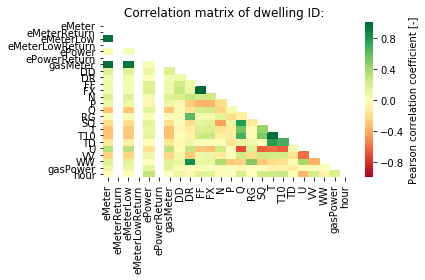

In [62]:
fig = create_corr_matrix(d, '', False)

## Select data we want

Saving heatmap


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

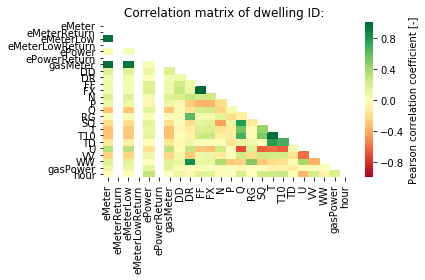

In [63]:
data = d
data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
fig = create_corr_matrix(d, '', False)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

data = data.drop(['U', 'N', 'Q', 'DD'], axis=1) # Drop columns with that have a |corr| > 0.1 with T

data = data[data['gasPower'] > 0] #filter data based on condition
data = data.dropna()

#sns.heatmap(data.corr(), annot=True)

# EDA

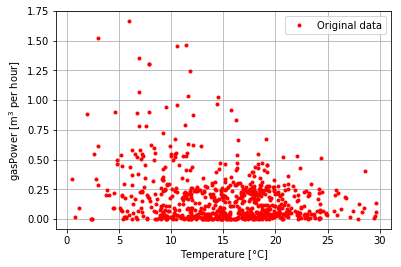

In [64]:
plt.plot(data['T'], data['gasPower'], '.', color='r', label='Original data')
plt.grid()
plt.xlabel('Temperature [°C]')
plt.ylabel('gasPower [m$^3$ per hour]')
plt.legend()

# Preprocessing

# Predict gasPower with most other variables

In [65]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

seed = 42

X = data.drop(['gasPower'], axis=1)
#X = data[['T']] # Only select T column
print('X columns final: %s' % list(X.columns))
#sns.heatmap(X.corr(), annot=True)

y = data[['gasPower']]

X = np.array(X).reshape(-1, len(X.columns))
y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

# fit scalers to training data
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
scalery = StandardScaler(with_mean=True, with_std=True).fit(y_train)

# Normalize X arrrays
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

# Get test data in the correct shape and format
y_train = np.array(y_train).reshape(-1,1) #reshape if y_train is not scaled, transforming should not be needed
y_test = np.array(y_test).reshape(-1,1)

def stats(ndarray):
    shape = ndarray.shape
    var = ndarray.var()
    mean = ndarray.mean()
    std = ndarray.std()
    min_ = ndarray.min()
    max_ = ndarray.max()
    return shape, var, mean, std, min_, max_

print('')
print('X_train -> \t shape: %s \t var: %.1f \t mean: %.1f \t std: %.1f, \t min: %.1f \t max: %.1f'% (stats(X_train)))
print('X_test -> \t shape: %s \t var: %.1f \t mean: %.1f \t std: %.1f, \t min: %.1f \t max: %.1f'% (stats(X_test)))
print('')
print('y_train -> \t shape: %s \t var: %.1E \t mean: %.1E  std: %.1E, \t min: %.1E \t max: %.1E'% (stats(y_train)))
print('y_test -> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E, \t min: %.1E \t max: %.1E'% (stats(y_test)))

X columns final: ['FF', 'RG', 'T', 'hour']

X_train -> 	 shape: (360, 4) 	 var: 1.0 	 mean: -0.0 	 std: 1.0, 	 min: -3.8 	 max: 11.8
X_test -> 	 shape: (360, 4) 	 var: 2.1 	 mean: 0.0 	 std: 1.5, 	 min: -3.8 	 max: 35.3

y_train -> 	 shape: (360, 1) 	 var: 6.0E-02 	 mean: 2.0E-01  std: 2.5E-01, 	 min: 1.8E-04 	 max: 1.7E+00
y_test -> 	 shape: (360, 1) 	 var: 4.4E-02 	 mean: 1.7E-01 	 std: 2.1E-01, 	 min: 3.1E-04 	 max: 1.5E+00


# Create the model

In [66]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time

In [67]:
# Create model
model = Sequential()

activation = 'relu'
#19
model.add(Dense(128, input_shape=(X_train.shape[1],), kernel_initializer='normal'))
model.add(Activation(activation))
model.add(Dropout(0.5, seed=seed)) 

# Dropout: 1 wont ''drop'' any data, 0.5 will drop half of the data
# https://www.quora.com/How-does-the-dropout-method-work-in-deep-learning-And-why-is-it-claimed-to-be-an-effective-trick-to-improve-your-network
N = 32*4 #45

for i in range(3):
    model.add(Dense(N, kernel_initializer='normal'))
    model.add(Activation(activation))
    model.add(Dropout(0.5, seed=seed))


model.add(Dense(1, kernel_initializer='normal'))
model.add(Activation('linear'))

# Compile & fit

In [68]:
%%bash
pwd

/home/16011015/notebooks/KB-74-OPSCHALER/Personal_folders/Brian/Keras


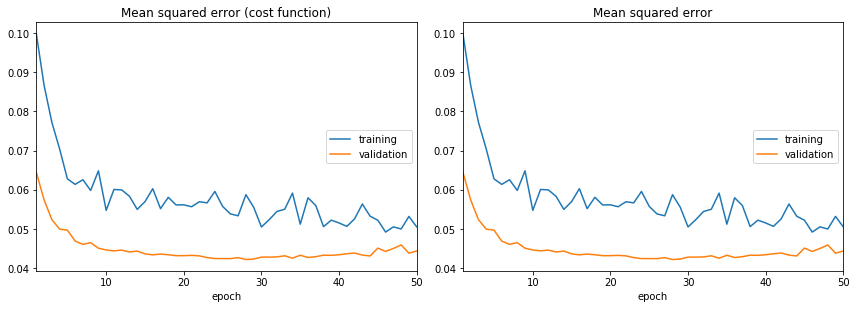

 - 0s - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 0.0444 - val_mean_squared_error: 0.0444
CPU times: user 32.5 s, sys: 1.87 s, total: 34.3 s
Wall time: 29.2 s


In [69]:
%%time

# Compile and fit
multi_model = multi_gpu_model(model, gpus=num_gpu)

lr = 0.55
epochs = 50
#decay_rate = 1*10**(-8)
decay_rate = 0
sgd = SGD(lr=lr, momentum=0.9, decay=decay_rate, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower

# compiling the sequential model
#multi_model.compile(loss='mean_squared_error', optimizer='adam')
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='nadam')

early_stopping_monitor = EarlyStopping(patience=5000)

from livelossplot import PlotLossesKeras

tensorboard = TensorBoard(log_dir="/home/16011015/notebooks/logs/{}".format(time()))

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)), 
                epochs=epochs, verbose=2, validation_data=(X_test, y_test), 
                callbacks=[early_stopping_monitor, PlotLossesKeras(), tensorboard])

# Plot results

In [ ]:
# X_test is already transformed
x_pred = X_test
#x_pred = scalerX.transform(x_pred)

y_pred = model.predict(x_pred)


print('x_pred scaled-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

x_pred = scalerX.inverse_transform(x_pred)
print('x_pred inverse-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

# select test variables
FF = x_pred[:,0]
RG = x_pred[:,1]
T = x_pred[:,2]

fig, axarr = plt.subplots(2,2)


axarr[0, 0].plot(data['T'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 0].plot(T, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 0].plot(T, y_pred, '.', color='b', label='Predicted', alpha=0.3)
axarr[0, 0].grid()
axarr[0, 0].set_xlabel('Temperature at 1,5 m $T$ [$\degree$C] \n (1 min mean)')
axarr[0, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')

axarr[0, 1].plot(data['RG'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 1].plot(RG, y_test, 'v', color='g', alpha=0.3, label='X_test, y_test')
axarr[0, 1].plot(RG, y_pred, '.', color='b', alpha=0.3, label='Predicted')
axarr[0, 1].grid()
axarr[0, 1].set_xlabel('Rain intensity $RG$ [mm/h] \n (10 min mean)')
axarr[0, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')


axarr[1, 0].plot(data['FF'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[1, 0].plot(FF, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 0].plot(FF, y_pred, '.', color='b', label='X_test, y_predicted', alpha=0.3)
axarr[1, 0].grid()
axarr[1, 0].set_xlabel('Wind speed $FF$ [m/s] \n (10 min mean)')
axarr[1, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')

fig.delaxes(axarr[1, 1])

mse = multi_model.evaluate(X_test, y_test)[0]
mse_val = str(mse)[:4]
mse_power = str(mse)[-1:]

#fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s $\cdot$ 10$^{-%s}$' % (mse_val, mse_power), fontsize = 14)
fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s' % (mse_val), fontsize = 14)

fig.set_size_inches(10,10)
fig.tight_layout()

fig.subplots_adjust(top=0.9) # Adjust title spacing at the top

axarr[1, 0].legend(loc='lower left', bbox_to_anchor= (1.25, 0.3), borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

In [ ]:
fig.savefig('DDN last result.png', dpi=1200)

In [ ]:
# Complete plot, commented out
# X_test is already transformed
x_pred = X_test
#x_pred = scalerX.transform(x_pred)

y_pred = model.predict(x_pred)


print('x_pred scaled-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

x_pred = scalerX.inverse_transform(x_pred)
print('x_pred inverse-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

# select test variables
DD = x_pred[:,0]
FF = x_pred[:,1]
N = x_pred[:,2]
Q = x_pred[:,3]
RG = x_pred[:,4]
T = x_pred[:,5]
U = x_pred[:,6]

fig, axarr = plt.subplots(3,3)

axarr[0, 0].plot(data['DD'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[0, 0].plot(DD, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 0].plot(DD, y_pred, 'x', color='b', label='X_test, y_predict', alpha=0.3)
axarr[0, 0].grid()
axarr[0, 0].set_xlabel('Wind direction $DD$ [$\degree$] \n (10 min mean)')
axarr[0, 0].set_ylabel(r'gasPower [m$^3$]')

axarr[0, 1].plot(data['N'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 1].plot(N, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 1].plot(N, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[0, 1].grid()
axarr[0, 1].set_xlabel('Total cloud coverage $N$ [octa]')
axarr[0, 1].set_ylabel(r'gasPower [m$^3$]')

axarr[0, 2].plot(data['Q'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 2].plot(Q, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 2].plot(Q, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[0, 2].grid()
axarr[0, 2].set_xlabel('global radiation $Q$ [W/m$^2$] \n (10 min mean)')
axarr[0, 2].set_ylabel(r'gasPower [m$^3$]')

axarr[1, 0].plot(data['RG'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[1, 0].plot(RG, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 0].plot(RG, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[1, 0].grid()
axarr[1, 0].set_xlabel('Rain intensity $RG$ [mm/h] \n (10 min mean)')
axarr[1, 0].set_ylabel(r'gasPower [m$^3$]')

axarr[1, 1].plot(data['T'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[1, 1].plot(T, y_test, 'v', color='g', alpha=0.3, label='X_test, y_test')
axarr[1, 1].plot(T, y_pred, 'x', color='b', alpha=0.3, label='Predicted')
axarr[1, 1].grid()
axarr[1, 1].set_xlabel('Temperature at 1,5 m $T$ [$\degree$C] \n (1 min mean)')
axarr[1, 1].set_ylabel(r'gasPower [m$^3$]')

axarr[1, 2].plot(data['U'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[1, 2].plot(U, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 2].plot(U, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[1, 2].grid()
axarr[1, 2].set_xlabel('Relative humidity at 1,5m $U$ [%] \n (1 min mean)')
axarr[1, 2].set_ylabel(r'gasPower [m$^3$]')

axarr[2, 0].plot(data['FF'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[2, 0].plot(FF, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[2, 0].plot(FF, y_pred, 'x', color='b', label='X_test, y_predicted', alpha=0.3)
axarr[2, 0].grid()
axarr[2, 0].set_xlabel('Wind speed $FF$ [m/s] \n (10 min mean)')
axarr[2, 0].set_ylabel(r'gasPower [m$^3$]')

fig.delaxes(axarr[2, 1])
fig.delaxes(axarr[2, 2])

mse = multi_model.evaluate(X_test, y_test)[0]
mse_val = str(mse)[:4]
mse_power = str(mse)[-1:]

fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s' % (mse_val), fontsize = 14)

fig.set_size_inches(10,10)
fig.tight_layout()



fig.subplots_adjust(top=0.9) # Adjust title spacing at the top

axarr[2, 0].legend(loc='lower left', bbox_to_anchor= (2, 0.3), borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

In [ ]:
fig.savefig('DDN last result.png', dpi=1200)